# robustgqg — Visual Demo Notebook

This notebook demonstrates some simple sanity checks for the implementations in `robustgqg`.

- Mean estimation under bounded covariance:
  - **Algorithm 1 — Explicit low‑regret** (KL I‑projection to the deleted simplex).
  - **Algorithm 2 — Filter** (renormalization to the simplex).

In [2]:
# Setup
import numpy as np
import matplotlib.pyplot as plt

from robustgqg.mean import MeanOptions, ExplicitLowRegretMean, FilterMean

## Mean Estimation (Algorithms 1 & 2)

We synthesize a contaminated dataset: inliers around an unknown mean $\mu^*$ with identity covariance, plus an $\varepsilon$ fraction of outliers.


In [3]:
# Synthetic mean-estimation dataset
def make_contaminated_mean_data(seed=0, n=700, d=6, eps=0.12, shift=12.0, scale=6.0):
    rng = np.random.default_rng(seed)
    k = int((1 - eps) * n)
    mu = rng.normal(size=d)
    X_good = rng.normal(loc=mu, scale=1.0, size=(k, d))
    X_bad = rng.normal(loc=mu + shift, scale=scale, size=(n - k, d))
    X = np.vstack([X_good, X_bad])
    idx = rng.permutation(n)
    return X[idx], mu, eps

X, mu_true, eps = make_contaminated_mean_data(seed=1, n=600, d=5, eps=0.12)
mu_naive = X.mean(axis=0)
print("X shape:", X.shape, " eps:", eps)

opts = MeanOptions(eps=eps, max_iter=600, eta=1.0, verbose=False)

# Fit Algo 1 (Explicit low-regret). Algorithm 1 uses KL I-projection from the paper.
est1 = ExplicitLowRegretMean(X, opts)
out1 = est1.run()
mu1 = out1["mu"]

# Fit Algo 2 (Filter — renormalization only)
est2 = FilterMean(X, opts)
out2 = est2.run()
mu2 = out2["mu"]

print("||mu_naive - mu_true||:", np.linalg.norm(mu_naive - mu_true))
print("||mu1 - mu_true||    :", np.linalg.norm(mu1 - mu_true))
print("||mu2 - mu_true||    :", np.linalg.norm(mu2 - mu_true))
print("F1, F2:", out1.get("F"), out2.get("F"))


X shape: (600, 5)  eps: 0.12
||mu_naive - mu_true||: 3.243462841257093
||mu1 - mu_true||    : 0.0963545423890261
||mu2 - mu_true||    : 0.11763731592898453
F1, F2: 1.165380258480349 0.8235232399376341


### Visual: data projected to 2D (Algo 1 weights)

We plot a 2D PCA projection of the dataset. Marker (dot) size reflects the weight $q_i$ learned by **Algorithm 1**. The robust mean (Algo 1, orange 'x') and naive mean (green '^') are overlaid.

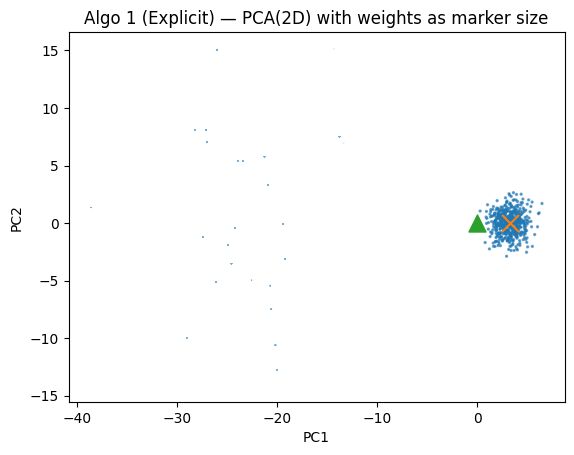

In [4]:
Xc = X - X.mean(axis=0)
U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
P2 = Xc @ Vt[:2].T  # (n,2)
q1 = out1["q"]

plt.figure()
plt.scatter(P2[:,0], P2[:,1], s=(1000 * q1), alpha=0.6)
plt.scatter([ (mu1 - X.mean(axis=0)) @ Vt[:2].T ][0][0], [ (mu1 - X.mean(axis=0)) @ Vt[:2].T ][0][1], marker='x', s=150)
plt.scatter([ (mu_naive - X.mean(axis=0)) @ Vt[:2].T ][0][0], [ (mu_naive - X.mean(axis=0)) @ Vt[:2].T ][0][1], marker='^', s=150)
plt.title("Algo 1 (Explicit) — PCA(2D) with weights as marker size")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.show()


### Visual: data projected to 2D (Algo 2 weights)

Same plot, with weights from **Algorithm 2 (Filter)**.

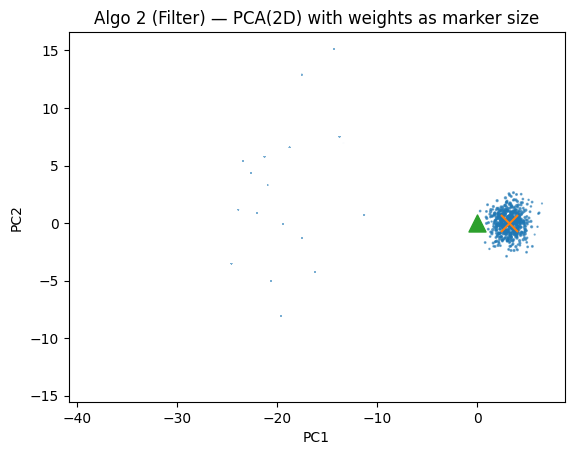

In [5]:
q2 = out2["q"]
plt.figure()
plt.scatter(P2[:,0], P2[:,1], s=(1000 * q2), alpha=0.6)
plt.scatter([ (mu2 - X.mean(axis=0)) @ Vt[:2].T ][0][0], [ (mu2 - X.mean(axis=0)) @ Vt[:2].T ][0][1], marker='x', s=150)
plt.scatter([ (mu_naive - X.mean(axis=0)) @ Vt[:2].T ][0][0], [ (mu_naive - X.mean(axis=0)) @ Vt[:2].T ][0][1], marker='^', s=150)
plt.title("Algo 2 (Filter) — PCA(2D) with weights as marker size")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.show()
